<div align="left">
<img align="left" src="../misc/cinlogo.jpg" height="60" width="60" >
<div> <b> UNET </b> </div>
<div> Pedro D. Marrero Fernandez</div>
<div> :), :(, :/</div>
</div>  

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import csv

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from skimage import io, transform
from skimage import color
import scipy.misc
import scipy.ndimage as ndi

from pytvision import visualization as view

sys.path.append('../')
from torchlib.datasets import imageutl as imutl
from torchlib import utils

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('fivethirtyeight')

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# Load original dataset datasciencebowl

In [2]:
pathdataset = '~/.datasets'
namedataset = 'datasciencebowl'
metadata = 'stage1_train_labels.csv'

pathname = os.path.join(pathdataset, namedataset);
pathmetadata = os.path.join(pathdataset, namedataset, metadata)

base_folder = pathname
sub_folder =  imutl.trainfile
id_file_name = metadata
folders_image='images'
folders_masks='masks'

dataloader = imutl.dsxbProvide.create(
    base_folder, 
    sub_folder, 
    id_file_name, 
    folders_image, 
    folders_masks
    )

print(len(dataloader))
print(':)!!!')

670
:)!!!


(360, 360, 3)
(360, 360, 23)


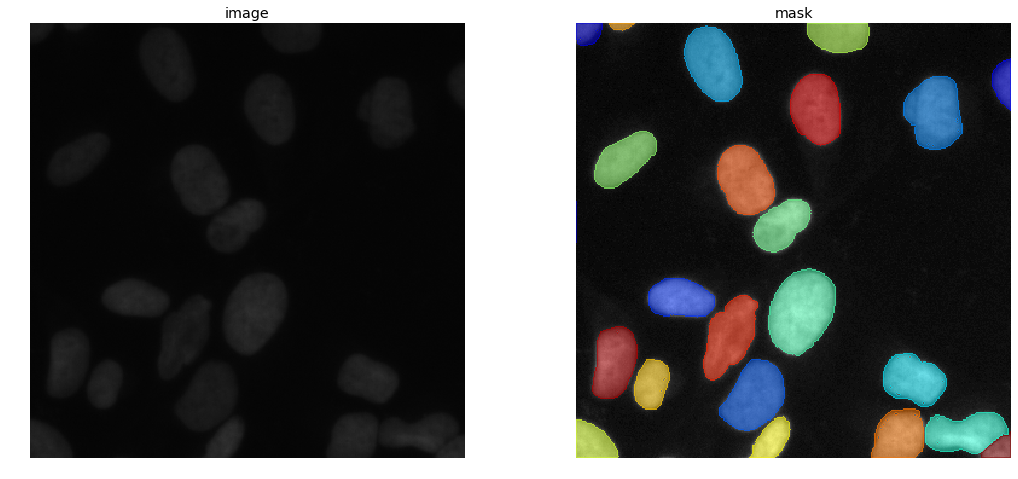

In [9]:
i=7
image, label = dataloader[ i ]

print(image.shape)
print(label.shape)

label = view.makeimagecell(image, label, alphaback=0.5, alphaedge=0.5)

plt.figure( figsize=(16,8) )
plt.subplot(121)
plt.imshow( image, cmap='gray' )
plt.axis('off')
# plt.title( dataloader.getid()[:-4] )
plt.title('image')
plt.subplot(122)
plt.imshow( label )
plt.axis('off')
plt.title( 'mask' )
plt.show()


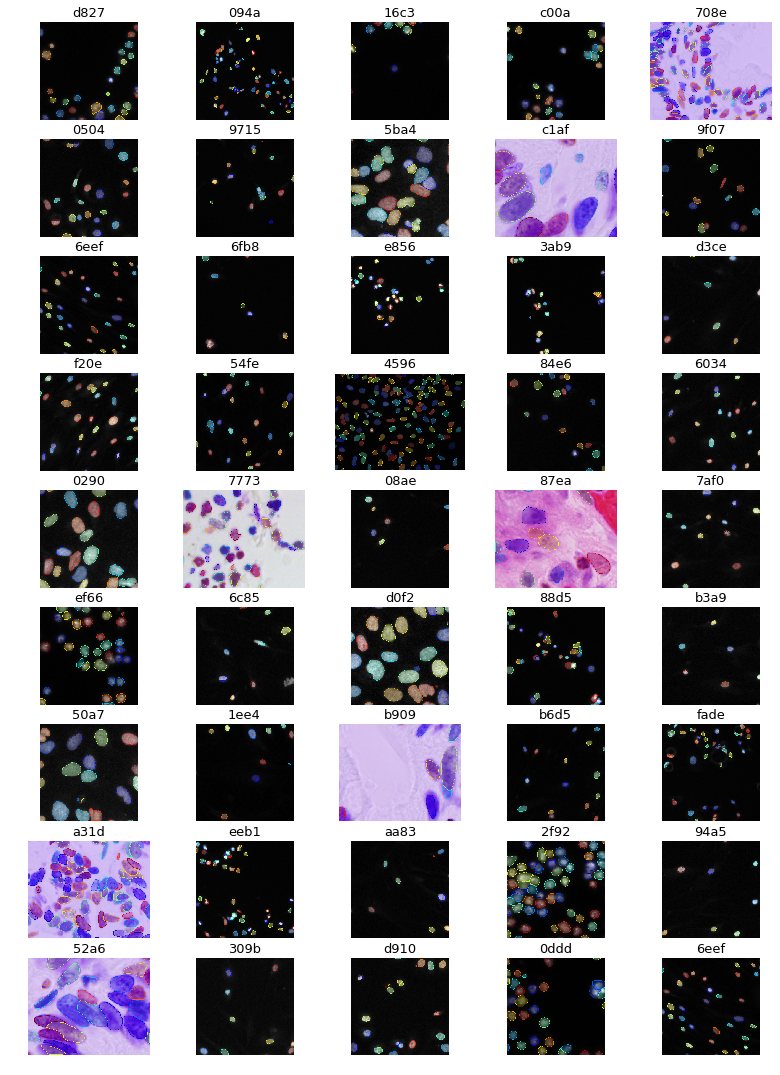

In [11]:
matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['figure.figsize'] = (12,19)

numRows = 9; numCols = 5

plt.figure()
for k in range(numRows*numCols):
    image, label = dataloader[ np.random.randint( len(dataloader) ) ]
    label = view.makeimagecell(image, label, alphaback=0.2, alphaedge=0.9)   
    plt.subplot(numRows,numCols,k+1); 
    plt.imshow( label )
    plt.title( dataloader.getid()[:4] ); 
    plt.axis('off')

## Create manual subclass datasets

In [26]:

grups = ['a','b','c','d','e','f','g']
for g in grups:
    files = np.loadtxt('../misc/grup_{}.txt'.format(g), delimiter=",")
    files = np.array(files).astype(np.uint32)
    total = len(files)
    image, label = dataloader[ files[0] ]
    w,h,c = image.shape
    print('{}\t{}\t{}x{}'.format(g,total,w,h) )
    

# files = np.loadtxt('../misc/grup_{}.txt'.format(grups[g]), delimiter=",")
# files = np.array(files).astype(np.uint32)
# print(files)
# print(files.shape)


a	16	1024x1024
b	66	256x320
c	6	603x1272
d	449	256x256
e	91	360x360
f	4	256x320
g	38	256x320


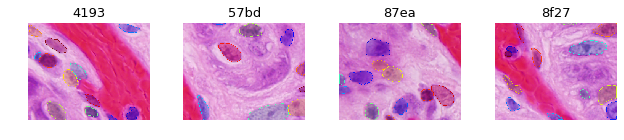

In [30]:

g = 5
files = np.loadtxt('../misc/grup_{}.txt'.format( grups[g] ), delimiter=",")
files = np.array(files).astype(np.uint32)

matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['figure.figsize'] = (12,19)

numRows = 9; numCols = 5

plt.figure()
for k in range( min(numRows*numCols, len(files)) ):
    image, label = dataloader[ files[k] ]
    label = view.makeimagecell(image, label, alphaback=0.2, alphaedge=0.9)   
    plt.subplot(numRows,numCols,k+1); 
    plt.imshow( label )
    plt.title( dataloader.getid()[:4] ); 
    plt.axis('off')
    
    

## Generate dataset

In [111]:
from torchlib import utils
from torchlib import preprocessing as prep
from skimage import morphology as morph
from scipy import ndimage

In [114]:
def imcrop( image, cropsize, top, left ):
    #if mult channel
    bchannel = False
    if len(image.shape) != 3:
        image = image[:,:,np.newaxis ]
        bchannel = True    
    h, w, c = image.shape
    new_h, new_w = cropsize
    imagecrop = image[top:top + new_h, left:left + new_w, : ]
    if bchannel:
        imagecrop = imagecrop[:,:,0]
    return imagecrop

def randomcrop(image, label, cropsize):
    h,w = image.shape[:2]
    new_h, new_w = cropsize
    top  = np.random.randint( h - new_h )
    left = np.random.randint( w - new_w )
    image = imcrop( image, cropsize, top, left)
    label = imcrop( label, cropsize, top, left)
    return image, label

def imrandomcrop(image, label, cropsize):
    barea = False    
    while barea==False:
        image_t, label_t = randomcrop(image, label, cropsize )
        masks = (label_t.transpose((2,0,1))>0).astype(np.uint32)
        masks = np.array([ ndimage.morphology.binary_fill_holes(x) for x in masks ])
        masks = utils.delete_black_layer(masks)
        barea = np.sum(masks) > 10
    return image_t, label_t, masks


In [90]:
# grups = ['a','b','c','d','e','f','g']
# for g in grups:
#     files = np.loadtxt('../misc/grup_{}.txt'.format(g), delimiter=",")
#     files = np.array(files).astype(np.uint32)
    
#     image, label = dataloader[0]
    
#     break

image, label = dataloader[20]
print(label.shape)

    

(256, 256, 6)


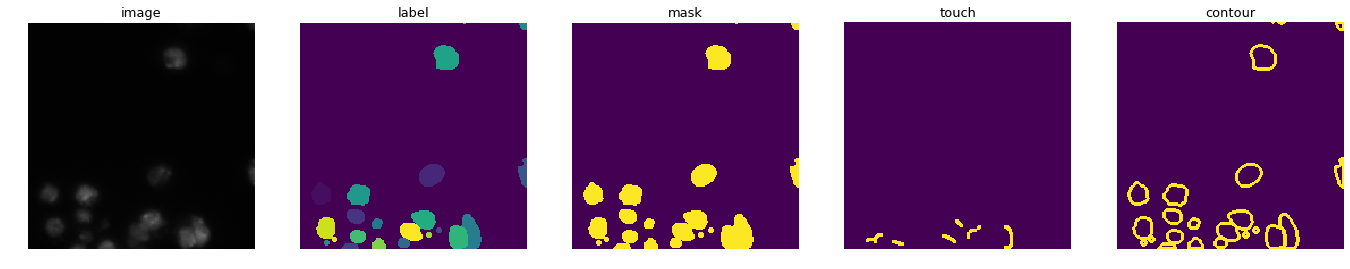

In [135]:
imsize=200

image, label = dataloader[0]
image, label, masks = imrandomcrop(image, label, (imsize,imsize) )

edges      = np.array([ morph.binary_dilation(prep.get_contour(x)) for x in masks ])       
bmask      = utils.tobinary( masks ).astype( np.uint8 )    
btouch     = prep.get_touchs( edges ).astype( np.uint8 )*255
bcontour   = utils.tobinary( edges ).astype( np.uint8 ) 
centers    = np.array([ morph.binary_dilation(prep.get_center(x)) for x in masks ]) 
bcenters   = utils.tobinary( centers ).astype( np.uint8 )

plt.figure( figsize=(21,8) )
plt.subplot(151)
plt.imshow(image, cmap='gray')
plt.title('image')
plt.axis('off')
plt.subplot(152)
plt.imshow(label.sum(axis=2))
plt.title('label')
plt.axis('off')
plt.subplot(153)
plt.imshow(bmask)
plt.title('mask')
plt.axis('off')
plt.subplot(154)
plt.imshow(btouch)
plt.title('touch')
plt.axis('off')
plt.subplot(155)
plt.imshow(bcontour)
plt.title('contour')
plt.axis('off')

plt.show()
